In [2]:
#Libraries
from math import floor, exp, sqrt, pi
import cmath
import numpy
from numpy import e, cos, zeros, arange, roll, where, random, ones, mean, reshape, dot, array, flipud, pi, exp, dot, angle, degrees, shape, linspace
import matplotlib.pyplot as plt
from itertools import chain
import scipy
from scipy import special
import numpy as np 
import seaborn as sns


In [98]:
#Parameters

totalTime=5000;
dt=2;
nsteps=int(floor(totalTime/dt));
num_cicles=10;

    
N=512;
origin = pi

#temporal variable (largerT --> smaller firing rate)
tauE=  60  #6; 
tauI=  10 #10; 
tauf =7000
taud =100



#Conductances (larger G means larger firing rate). Diff cond. for connections
# GEE=  0.05
# GEI=  0.03 #0.03 
# GIE=  0.03
# GII=  0.02
I0E=  1.3   ####1.9##0.2; (as it decreases --> less bumps)
I0I=  0.4    ##0.5; (as it increases --> less bumps)
U =0.5
#Realted with noise
sigE=  0.06 #1.5 #1 #0.5 ;
sigI=  0.04 #1.6 #2 #1.3 ;



GEE=  0.021
GEI=  0.032 
GIE=  0.012  
GII=  0.007  
#Realted with noise
# sigE=  1.5 #1.5 #1 #0.5 ;
# sigI=  1.6 #1.6 #2 #1.3 ;



#Stimulus (when on and off, separation between them and strenght)
targ_onset = 200;
targ_offset = 700;
dist_onset = 9900 #3000 
dist_offset = 91400 #3500 

n_stims=2; #2
stim_sep = pi/16 ###13 --> 2   (13 attract, 9 solo 1, 5 repulsion, 2 nada)
#stim_sep=0



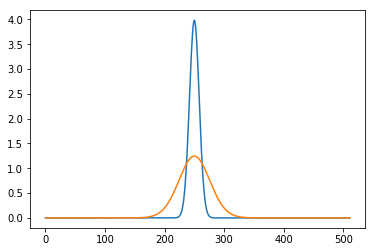

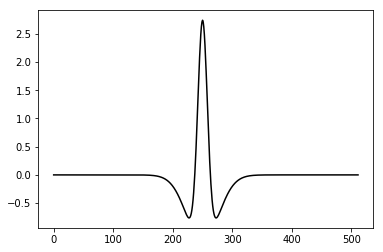

In [99]:
#Connectivities

kappa_E=  100  # 100  1/k in vaon misses is std    ( https://en.wikipedia.org/wiki/Von_Mises_distribution) 
kappa_I= 10 ###2.9 

v_E=zeros((N));
v_I=zeros((N));
WE=zeros((N,N));
WI=zeros((N,N));


theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)] 

for i in range(0, N):
    v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
    v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) for f in range(0, len(theta))] #0.18
    ###    
    vE_NEW=roll(v_E_new,i)
    vI_NEW=roll(v_I_new,i) #to roll
    ###    
    WE[:,i]=vE_NEW
    WI[:,i]=vI_NEW

    
    
    
plt.plot(WE[250, :])
plt.plot(WI[250, :])
plt.show(block=False)

topography_pattern  =  WE[250, :] + -1*(WI[250, :])
plt.plot(topography_pattern, 'k')
plt.show(block=False)



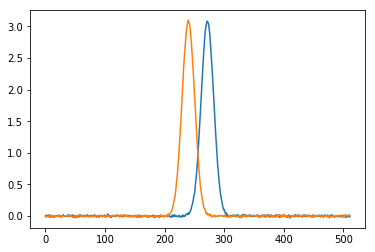

In [100]:
# stims

kappa_stim= 60

target=zeros((N))
distractor=zeros((N))

for i in range(0, N):
    target[i]=e**(kappa_stim*cos(theta[i] + origin - stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 
    distractor[i]=e**(kappa_stim*cos(theta[i] + origin + stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 


target = target+ np.random.normal(0, 0.01, N)
target=reshape(target, (N,1)) 


distractor = distractor+ np.random.normal(0, 0.01, N)
distractor=reshape(distractor, (N,1)) 

    
######################

targon = floor(targ_onset/dt);
targoff = floor(targ_offset/dt);

diston = floor(dist_onset/dt);
distoff = floor(dist_offset/dt);

plt.plot(target)
plt.plot(distractor)
plt.show(block=False)

In [101]:
#Simulation

rE=zeros((N,1));
rI=zeros((N,1)); 
u = np.ones((N,1))*U
x = np.ones((N,1))

#generation of the noise and the connectivity between inhib and exit
RE=zeros((N,nsteps));
RI=zeros((N,nsteps));
p_u=np.ones((N,nsteps));
p_x=np.ones((N,nsteps));

f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)


### diferential equations
for i in range(0, nsteps):
    noiseE = sigE*random.randn(N,1);
    noiseI = sigI*random.randn(N,1);
    
    #differential equations for connectivity
    IE= GEE*dot(WE, (rE*u*x)) - GIE*dot(WI,rI) + I0E*ones((N,1)); 
    II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));
    
    if i>targon and i<targoff:
        IE=IE+target;
        II=II+target;
    
    if i>diston and i<distoff:
        IE=IE+distractor;
        II=II+distractor;
    
    
    #rates of exit and inhib   
    rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
    rI = rI + (f(II) - rI + noiseI)*dt/tauI;
    #re_norm = (rE-min(rE))/(   max(rE) - min(rE));    
    ### formulas:
    #### paper mongillo 2008
    #### http://www.scholarpedia.org/article/Short-term_synaptic_plasticity
    ##
    u = u + ((U - u) / tauf + U*(1-u)*rE/1000)*dt;
    x = x + ((1 - x)/taud - u*x*rE/1000)*dt;
    
    
    
    #
    #####facilitation = facilitation + ( - (facilitation-1) + k_Ca * rE ) *dt/tauCa 
    
    rEr=reshape(rE, N)
    rIr=reshape(rI, N)
    ur=reshape(u, N)
    xr=reshape(x, N)
    #drawnow
    RE[:,i] = rEr;
    RI[:,i] = rIr;
    p_u[:,i] = ur;
    p_x[:,i] = xr;
    






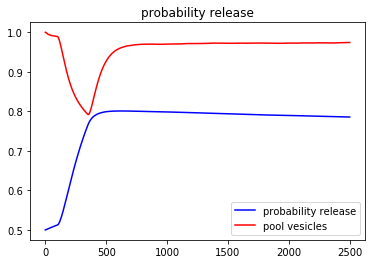

In [102]:
p_targ = int((N * np.degrees(origin + stim_sep))/360)
p_dist= int((N * np.degrees(origin - stim_sep))/360)

plt.title('probability release')
plt.plot(p_u[p_targ, :], 'b', label='probability release')
plt.plot(p_x[p_targ, :], 'r', label='pool vesicles')
plt.legend()


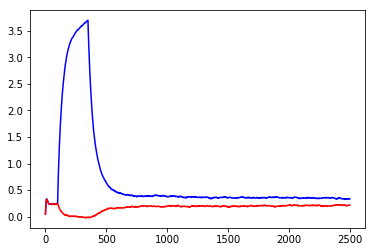

In [103]:
plt.plot(RE[p_targ, :], 'b', label='target')
plt.plot(RE[p_dist, :], 'r', label='distractor')

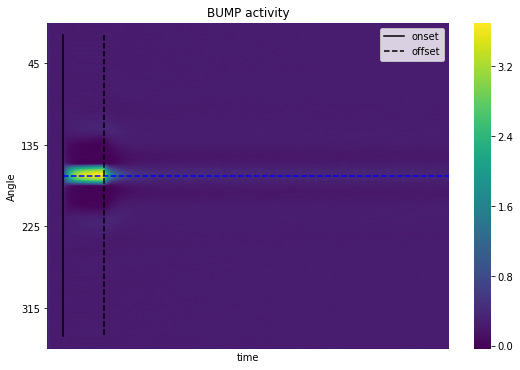

In [104]:
### Plot of activity
RE_sorted=flipud(RE)
plt.figure(figsize=(9,6))
sns.heatmap(RE_sorted, cmap='viridis')
plt.title('BUMP activity')
plt.ylabel('Angle')
plt.xlabel('time')
plt.plot([targon, nsteps], [p_dist, p_dist], '--b',) ## flipped, so it is p_target 
plt.plot([diston, nsteps], [p_targ, p_targ], '--r',) ## flipped, so it is p_target 
plt.yticks([])
plt.xticks([])

plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])

plt.plot([targ_onset/2, targ_onset/2,], [0+20, N-20], 'k-', label='onset')
plt.plot([targ_offset/2, targ_offset/2,], [0+20, N-20], 'k--', label='offset')

plt.plot([dist_onset/2, dist_onset/2,], [0+20, N-20], 'k-')
plt.plot([dist_offset/2, dist_offset/2,], [0+20, N-20], 'k--')

plt.legend()
plt.show(block=False)